# DYOD - Using ANN from Kudzu Lirary
> Distinguishing handwritten digits taken from mnist library using a Multi Layer Perceptron

- branch: master
- badges: true
- comments: true
- author: PrasannaDK
- categories: [fastpages, jupyter]
- date: 2020-08-06

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
!pip install mnist

## Preparing the Data

In [4]:
import mnist

In [5]:
train_images = mnist.train_images()
train_labels = mnist.train_labels()

In [6]:
train_images.shape, train_labels.shape

((60000, 28, 28), (60000,))

In [7]:
test_images = mnist.test_images()
test_labels = mnist.test_labels()

In [8]:
test_images.shape, test_labels.shape

((10000, 28, 28), (10000,))

2


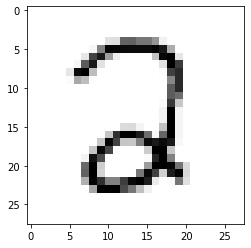

In [9]:
image_index = 7776 # You may select anything up to 60,000
print(train_labels[image_index]) 
plt.imshow(train_images[image_index], cmap='Greys')

## Filter data to get 3 and 8 out

In [10]:
train_filter = np.where((train_labels == 3 ) | (train_labels == 8))
test_filter = np.where((test_labels == 3) | (test_labels == 8))
X_train, y_train = train_images[train_filter], train_labels[train_filter]
X_test, y_test = test_images[test_filter], test_labels[test_filter]



We normalize the pizel values in the 0 to 1 range

In [11]:
X_train = X_train/255.
X_test = X_test/255.

And setup the labels as 1 (when the digit is 3) and 0 (when the digit is 8)

In [12]:
y_train = 1*(y_train==3)
y_test = 1*(y_test==3)

In [13]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((11982, 28, 28), (1984, 28, 28), (11982,), (1984,))

We reshape the data to flatten the image pixels into a set of features or co-variates:

In [14]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train.shape, X_test.shape, y_train.shape

((11982, 784), (1984, 784), (11982,))

### 1. Use the following configuration (or similar) to set up your model for training.

```pythom
class Config:
    pass
config = Config()
config.lr = 0.001
config.num_epochs = 200
config.bs = 50
```

Make sure you import everything you need from the kudzu library provided. Fell free to change it if needed, but mention that in your solutions.


Now construct a model which has the following layers

1. A first affine layer which has 784 inputs and does 100 affine transforms. These are followed by a `Relu`
2. A second affine layer which has 100 inputs from the 100 activations of the past layer, and does 100 affine transforms. These are followed by a `Relu`
3. A third affine layer which has 100 activations and does 2 affine transformations to create an embedding for visualization. There is no non-linearity here.
4. A final "logistic regression" which has an affine transform from 2 inputs to 1 output, which is squeezed through a sigmoid.

### 2. Create a callback class

Lets call it `ClfCallback` or classifier-callback. You can build it as a subclass of `AccClallback` or just copy and paste the code. But it needs some new functionality:

1. Initialize it to have accuracy arrays 

```python
        self.accuracies = []
        self.test_accuracies = []
```
2. Then at the end of each epoch, calculate the probabilities and hence predictions on both the training set and the test set. Print these out once per epoch. Acumulate these in the above array. This will require you to keep track of all 4 training and test sets. You can edit the `Learner` for this or pass these sets in some kind of data object to the callback.

### 3. Train the model

Train the model for 200, or if needed, some more epochs with a low learning rate. You will find that your losses will not have converged to a completely flat level before gradients start to blow up. The reason for this is the high or low probability instabilities (the $\frac{dL}{dp}$ gradient) , and also possibly other numerical instabilities..see http://fa.bianp.net/blog/2019/evaluate_logistic/ for more details.

Stop the training at 200-300 epochs. When you plot the training and validation accuracies you will see the model is already overfitting: the validation accuracy will have dipped below the training accuracy, and they are diverging.

Overfitting happens when your model is quite complex and is fitting to the noise in the training set rather than the signal.

### 4. Plot the results

What accuracy do we get? How many False positives and False negatives.

Specifically, in the embedding space ( the inputs of the "logistic regression") plot the data points by running them forward through the network. Color code them with their actual class and plot the probability contours (these will all be lines in the embedding space as from here on, this is a logistic regression). This plot should allow one to see the points stranded on the "wrong" side of the probability 1/2 line. Also plot the predictions against the actual values on a plot of your choice, showing where they are in the embedding space.

### 5. OPTIONAL AND EXTRA CREDIT

1. Compare your neural network to a simple logistic regression model.
2. Put your notebook on your blog, communicating how you carried out your analysis.

In [15]:
from kudzu.data import Data, Dataloader, Sampler
from kudzu.callbacks import AccCallback, ClfCallback
from kudzu.loss import MSE, BCE
from kudzu.layer import Affine, Sigmoid, Relu, Tanh
from kudzu.model import Model
from kudzu.optim import GD
from kudzu.train import Learner

In [16]:
from collections import namedtuple

In [17]:
class Config:
    pass
config = Config()
config.lr = 0.001
config.num_epochs = 250
config.bs = 50

In [18]:
dataSets = namedtuple('dataSets', ['X_train','y_train', 'X_test','y_test'])
dataSet = dataSets(X_train, y_train.reshape(-1,1), X_test, y_test.reshape(-1,1))

In [19]:
data = Data(dataSet.X_train, dataSet.y_train)
loss = BCE()
opt = GD(config.lr)
sampler = Sampler(data, config.bs, shuffle=True)
dl = Dataloader(data, sampler)

In [20]:
nn_layers = [Affine("FirstAffine", 784, 100),  Relu("FirstRelu"), Affine("SecondAffine", 100, 100), Relu("SecondRelu"), Affine("Embedding", 100, 2), Affine("LastAffine", 2, 1), Sigmoid("LastSigmoid")]
nn_model = Model(nn_layers)

In [21]:
nn_learner = Learner(loss, nn_model, opt, config.num_epochs)
nn_acc = ClfCallback(nn_learner, config.bs, dataSet)
nn_learner.set_callbacks([nn_acc])

In [22]:
nn_learner.train_loop(dl)

Epoch 0 Loss 0.703960564401036
Epoch 0 Train-Accuracy 0.6102487063929227 Test-Accuracy 0.6365927419354839
Epoch 10 Loss 0.19209384510115626
Epoch 10 Train-Accuracy 0.942663995993991 Test-Accuracy 0.954133064516129
Epoch 20 Loss 0.12594689046508645
Epoch 20 Train-Accuracy 0.9589384076114171 Test-Accuracy 0.9657258064516129
Epoch 30 Loss 0.10791700845655369
Epoch 30 Train-Accuracy 0.9648639626105825 Test-Accuracy 0.96875
Epoch 40 Loss 0.09810353359425117
Epoch 40 Train-Accuracy 0.9686195960607578 Test-Accuracy 0.9707661290322581
Epoch 50 Loss 0.0909123131331838
Epoch 50 Train-Accuracy 0.971039893173093 Test-Accuracy 0.9712701612903226
Epoch 60 Loss 0.08493062656646135
Epoch 60 Train-Accuracy 0.9725421465531631 Test-Accuracy 0.9722782258064516
Epoch 70 Loss 0.07935591724431465
Epoch 70 Train-Accuracy 0.9750459021866132 Test-Accuracy 0.9722782258064516
Epoch 80 Loss 0.07421329625613284
Epoch 80 Train-Accuracy 0.9772992822567184 Test-Accuracy 0.9737903225806451
Epoch 90 Loss 0.0693621378211

0.019416251800245372

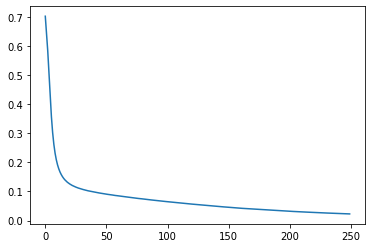

In [23]:
plt.plot(nn_acc.losses)

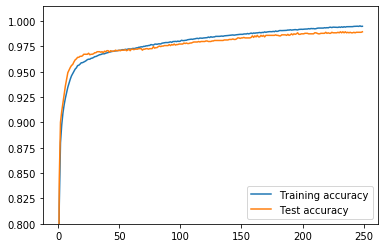

In [24]:
plt.plot(nn_acc.accuracies, label = 'Training accuracy')
plt.plot(nn_acc.test_accuracies, label = 'Test accuracy')
plt.ylim(0.8)
plt.legend();

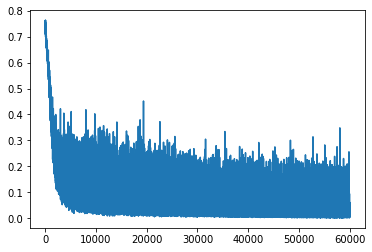

In [25]:
plt.plot(nn_acc.batch_losses)

In [26]:
#plt.plot(nn_acc.get_biases('Embedding'))

In [27]:
nn_probs_train = nn_model(dataSet.X_train)
print(nn_probs_train[:10])
nn_predictions_train = (nn_probs_train >= 0.5)*1
nn_validateTrain = (nn_predictions_train == dataSet.y_train)
nn_validateTrain_acc = np.mean(nn_validateTrain)
nn_validateTrain_acc

[[9.99998249e-01]
 [9.99967580e-01]
 [9.99999971e-01]
 [3.43871083e-04]
 [9.99999976e-01]
 [9.99505677e-01]
 [3.33152609e-04]
 [4.80224059e-04]
 [9.99947485e-01]
 [3.03612091e-03]]


0.9948255716908696

In [28]:
nn_validateTest = (nn_model(dataSet.X_test) >= 0.5)*1 == dataSet.y_test
nn_validateTest_acc = np.mean(nn_validateTest)
nn_validateTest_acc

0.9894153225806451

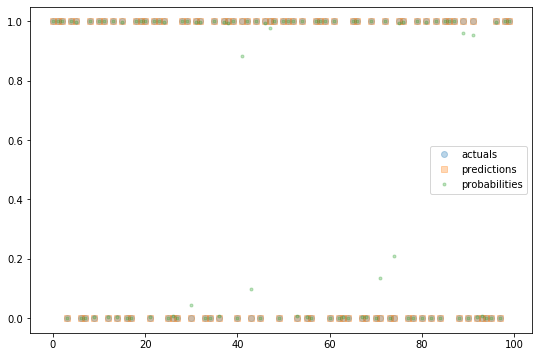

In [29]:
plt.figure(figsize=(9, 6))
plt.plot(dataSet.y_train[:100], 'o',alpha=0.3, label="actuals")
plt.plot(nn_predictions_train[:100], 's',alpha=0.3, label="predictions")
plt.plot(nn_probs_train[:100],'.', alpha=0.3, label="probabilities")
#plt.axvline(-b/w, 0,1,color='r', alpha=0.4, label="dividing line")
plt.legend();

In [30]:
from sklearn.metrics import confusion_matrix
confMat = confusion_matrix(dataSet.y_train, nn_predictions_train)
confMat

array([[5829,   22],
       [  40, 6091]], dtype=int64)

In [31]:
#FalseNegatives
falseNegatives = confMat[1,0]
falseNegatives

40

In [32]:
#FalsePositives
falsePositives = confMat[0,1]
falsePositives

22

In [33]:
#Embedding space
#layers = [Affine("FirstAffine", 784, 100),  Relu("FirstRelu"), Affine("SecondAffine", 100, 100), Relu("SecondRelu"), Affine("Embedding", 100, 2), Affine("LastAffine", 2, 1), Sigmoid("LastSigmoid")]
FirstAffine = nn_model.layers[0]
FirstRelu = nn_model.layers[1]
SecondAffine = nn_model.layers[2]
SecondRelu = nn_model.layers[3]
Embedding = nn_model.layers[4]
embOutput = Embedding(SecondRelu(SecondAffine(FirstRelu(FirstAffine(dataSet.X_train)))))
embOutput

array([[ 4.77398124,  3.92769468],
       [ 3.7568011 ,  3.01150055],
       [ 6.16942796,  5.25388745],
       ...,
       [-2.07165688, -2.4491103 ],
       [ 2.91030136,  2.05820631],
       [-2.13532001, -2.64191557]])

In [34]:
#plt.scatter(np.linspace(np.min(embOutput[:1000,0]),np.max(embOutput[:1000,0]),1000), embOutput[:1000,0])
#plt.scatter(np.linspace(np.min(embOutput[:1000,1]),np.max(embOutput[:1000,1]),1000),embOutput[:1000,1])

In [35]:
embOutput[:,0]

array([ 4.77398124,  3.7568011 ,  6.16942796, ..., -2.07165688,
        2.91030136, -2.13532001])

In [36]:
emb_3 = embOutput[y_train==1]
emb_8 = embOutput[y_train==0]
emb_3.shape, emb_3, emb_8.shape, emb_8

((6131, 2),
 array([[4.77398124, 3.92769468],
        [3.7568011 , 3.01150055],
        [6.16942796, 5.25388745],
        ...,
        [4.95659926, 4.16659977],
        [3.05681906, 2.36381269],
        [2.91030136, 2.05820631]]),
 (5851, 2),
 array([[-2.42693612, -2.97987132],
        [-2.06841305, -3.44102668],
        [-2.65836613, -2.45023144],
        ...,
        [-2.40252518, -2.68985916],
        [-2.07165688, -2.4491103 ],
        [-2.13532001, -2.64191557]]))

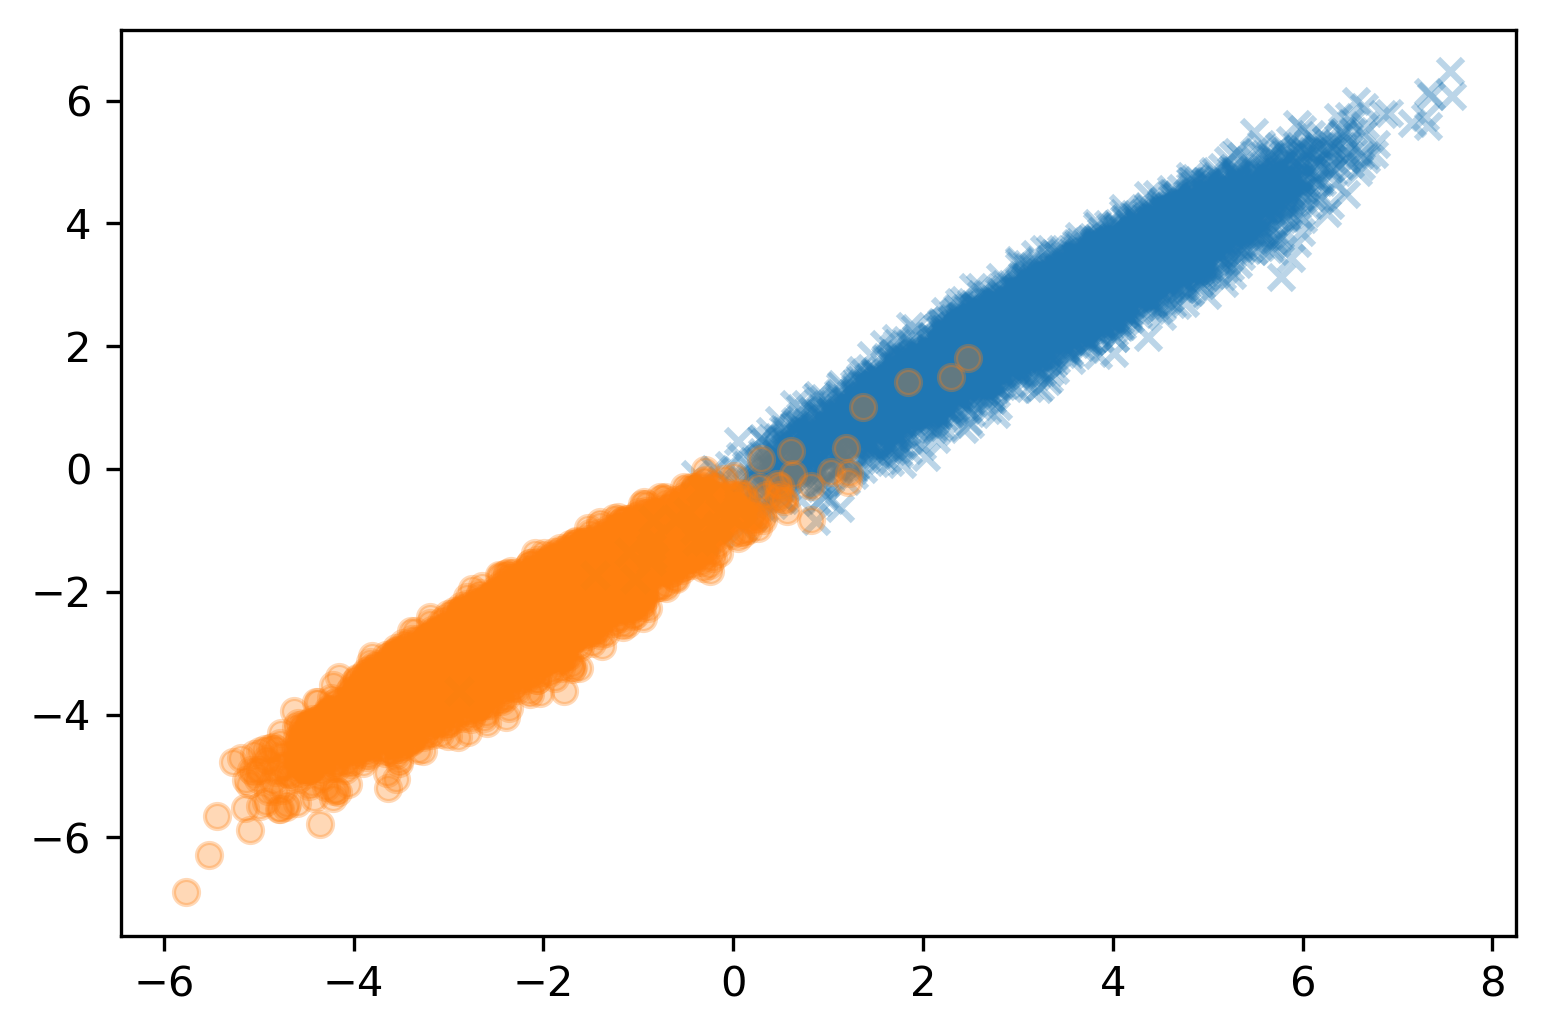

In [37]:
plt.figure(dpi=300)
plt.scatter(emb_3[:,0], emb_3[:,1], alpha = 0.3,marker = 'x')
plt.scatter(emb_8[:,0], emb_8[:,1], alpha = 0.3)

In [38]:
b1, w1, w2 = nn_acc.get_biases('LastAffine')[-1], nn_acc.get_weights('LastAffine', 0)[-1], nn_acc.get_weights('LastAffine', 1)[-2]
b1, w1, w2

(0.061680500493359894, 1.6510359309018159, 1.3509873489030384)

In [39]:
params = nn_model.layers[5].params
w1, w2, b = params['w'][0,0], params['w'][1,0], params['b'][0]
w1, w2, b

(1.6510359309018159, 1.3522803928683884, 0.061680500493359894)

In [40]:
affineLine = lambda x1, x2 : w1*x1 + w2*x2 + b
sigmoidProb = lambda x1, x2: 1 / (1 + np.exp(-affineLine(x1,x2)))  

In [41]:
xgrid = np.linspace(np.min(embOutput[:,0])-1, np.max(embOutput[:,0])+1, 1000)
ygrid = np.linspace(np.min(embOutput[:,1])-1, np.max(embOutput[:,1])+1, 1000)

In [42]:
X, Y = np.meshgrid(xgrid, ygrid)
X.shape, Y.shape

((1000, 1000), (1000, 1000))

(1000, 1000)


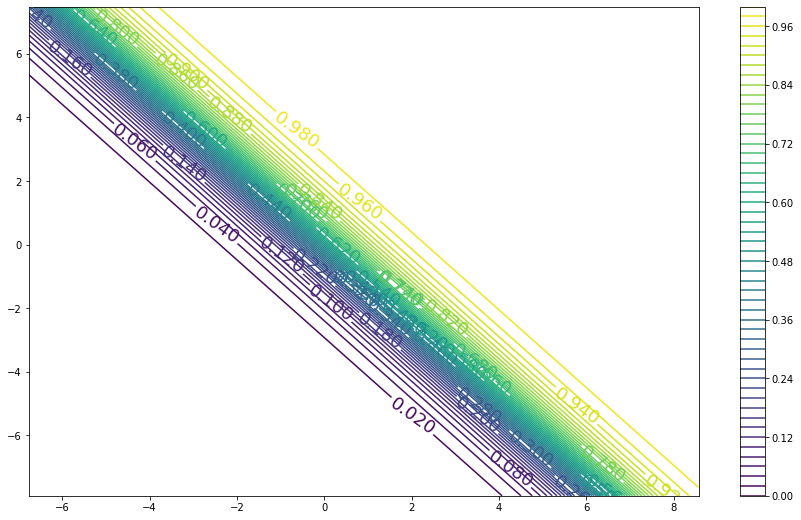

In [43]:
Z = sigmoidProb(X, Y)
print(Z.shape)
plt.figure(figsize=(15, 9))
contours = plt.contour(X, Y, Z,50)
plt.clabel(contours, inline=True, fontsize=18)
plt.colorbar();

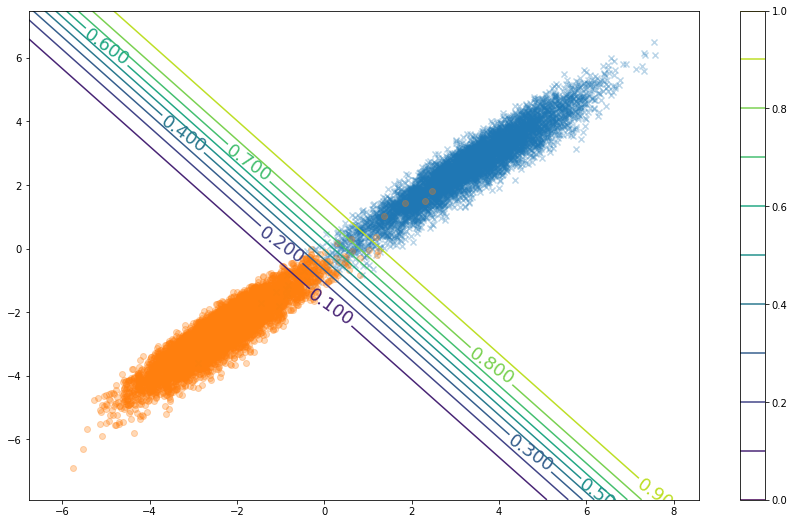

In [44]:
plt.figure(figsize=(15, 9))
contours = plt.contour(X, Y, Z, 10)
plt.clabel(contours, inline=True, fontsize=18)
plt.colorbar();
plt.scatter(emb_3[:,0], emb_3[:,1], alpha = 0.3,marker = 'x')
plt.scatter(emb_8[:,0], emb_8[:,1], alpha = 0.3)

In [45]:
z1 = sigmoidProb(emb_3[:,0], emb_3[:,1])
z2 = sigmoidProb(emb_8[:,0], emb_8[:,1])
z1, z2

(array([0.99999825, 0.99996758, 0.99999997, ..., 0.99999906, 0.99975282,
        0.99952417]),
 array([0.00034387, 0.00033315, 0.00048022, ..., 0.00052983, 0.00126605,
        0.0008785 ]))

In [46]:
np.max(z1), np.min(z1), np.max(z2), np.min(z2)

(0.9999999994329152,
 6.880654432694066e-05,
 0.998628208273472,
 6.986733231403488e-09)

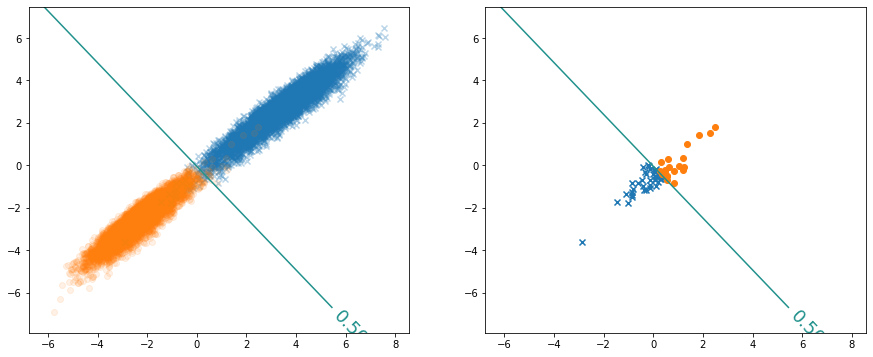

In [47]:
plt.figure(figsize=(15, 6))
plt.subplot(121)
contours = plt.contour(X, Y, Z, 1)
plt.clabel(contours, inline=True, fontsize=18)
plt.scatter(emb_3[:,0], emb_3[:,1], alpha = 0.3,marker = 'x')
plt.scatter(emb_8[:,0], emb_8[:,1], alpha = 0.1)
plt.subplot(122)
contours = plt.contour(X, Y, Z, 1)
plt.clabel(contours, inline=True, fontsize=18)
plt.scatter(emb_3[z1 < 0.5, 0], emb_3[z1 < 0.5, 1], alpha = 1,marker = 'x')
plt.scatter(emb_8[z2 >= 0.5, 0], emb_8[z2 >= 0.5, 1], alpha = 1)

In [48]:
from mpl_toolkits.mplot3d import Axes3D

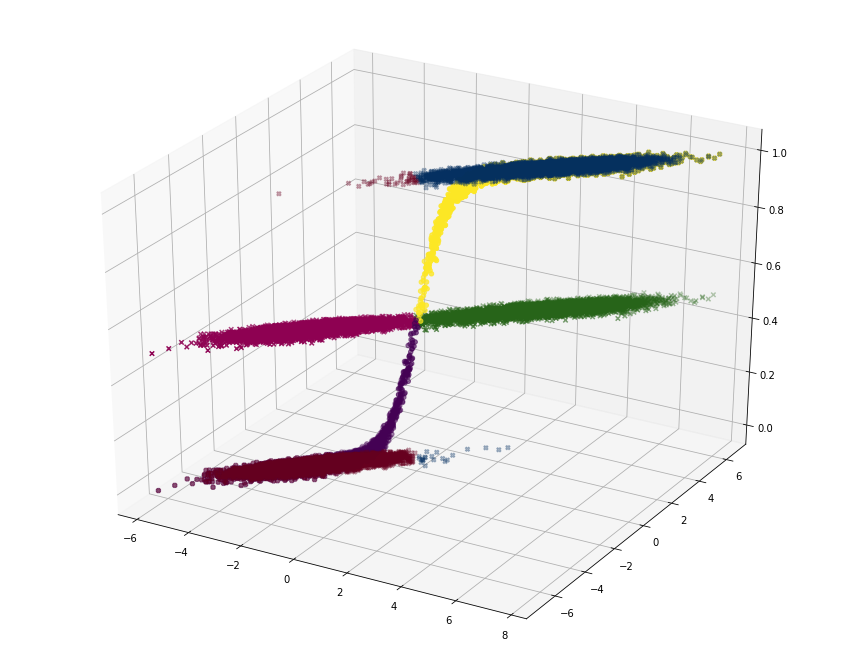

In [50]:
fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(111, projection='3d')
l, m, n = embOutput[:,0], embOutput[:,1], sigmoidProb(embOutput[:,0],embOutput[:,1])
ax.scatter(l, m, n, c = n >= 0.5, marker='o')    #Plotting the probabilities in 3-D space
#ax.scatter(l, m, 1*(n>0.5), c = (1*(n>0.5) == y_train[:]), marker ='s', cmap="RdBu", alpha = 0.3)    #Plotting the predictions with color coding from comparison with the actuals, thus showing the wrongly classified points
ax.scatter(l, m, y_train[:], c = n >= 0.5, marker ='X', cmap="RdBu", alpha = 0.3)    #Plotting the actuals with color coding from predictions, thus showing the wrongly classified points
ax.scatter(l, m, 0.5, c = n >= 0.5, marker='x', cmap="PiYG")    #Plotting the embedding space across the middle
#i , j = np.meshgrid(embOutput[:100,0], embOutput[:100,1])
#ax.plot_surface(i, j, sigmoidProb(i, j))
plt.show()

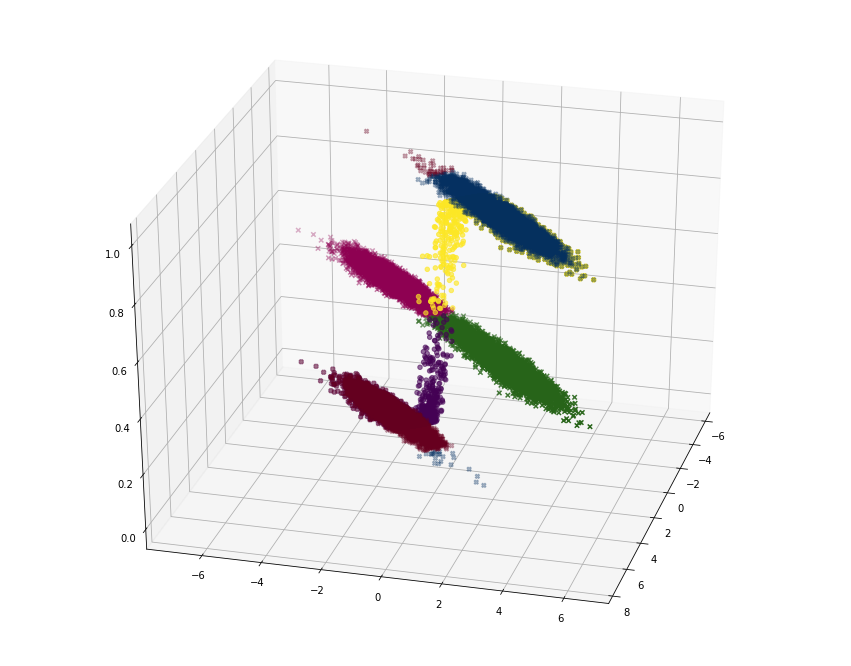

In [51]:
ax.view_init(elev=30, azim=15)
fig

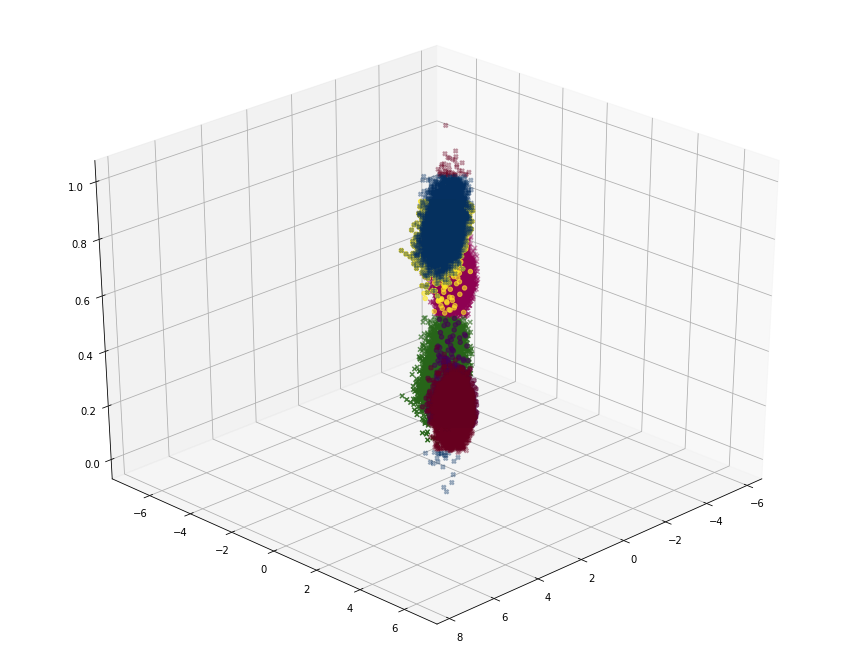

In [52]:
ax.view_init(elev=30, azim=45)
fig

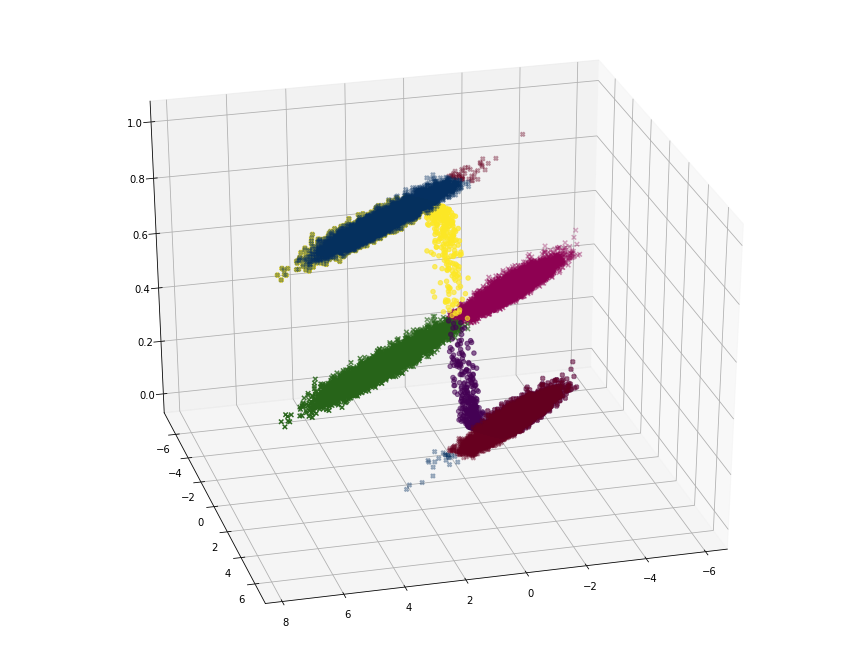

In [53]:
ax.view_init(elev=30, azim=75)
fig

In [54]:
lr_layers = [Affine("FirstAffine", 784, 1), Sigmoid("LastSigmoid")]
lr_model = Model(lr_layers)

In [55]:
lr_learner = Learner(loss, lr_model, opt, config.num_epochs)
lr_acc = ClfCallback(lr_learner, config.bs, dataSet)
lr_learner.set_callbacks([lr_acc])

In [56]:
lr_learner.train_loop(dl)

Epoch 0 Loss 0.6587826823472179
Epoch 0 Train-Accuracy 0.7874311467200801 Test-Accuracy 0.8099798387096774
Epoch 10 Loss 0.26623218976937124
Epoch 10 Train-Accuracy 0.927891837756635 Test-Accuracy 0.938508064516129
Epoch 20 Loss 0.21207356492510365
Epoch 20 Train-Accuracy 0.9378234017693207 Test-Accuracy 0.9526209677419355
Epoch 30 Loss 0.18702369782467407
Epoch 30 Train-Accuracy 0.9440827908529461 Test-Accuracy 0.9546370967741935
Epoch 40 Loss 0.17198380977852037
Epoch 40 Train-Accuracy 0.9480053413453514 Test-Accuracy 0.9556451612903226
Epoch 50 Loss 0.16176254649544985
Epoch 50 Train-Accuracy 0.9511767651477215 Test-Accuracy 0.9571572580645161
Epoch 60 Loss 0.1542825406823085
Epoch 60 Train-Accuracy 0.9531797696544817 Test-Accuracy 0.9616935483870968
Epoch 70 Loss 0.14852224892694776
Epoch 70 Train-Accuracy 0.9547654815556669 Test-Accuracy 0.9632056451612904
Epoch 80 Loss 0.14391833964157602
Epoch 80 Train-Accuracy 0.956017359372392 Test-Accuracy 0.9642137096774194
Epoch 90 Loss 0.1

0.04219699272417273

In [57]:
lr_predictions_train = (lr_model(dataSet.X_train) >= 0.5)*1
lr_validateTrain = ( lr_predictions_train == dataSet.y_train)
lr_validateTrain_acc = np.mean(lr_validateTrain)
lr_validateTrain_acc

0.9642797529627775

In [58]:
lr_validateTest = (lr_model(dataSet.X_test) >= 0.5)*1 == dataSet.y_test
lr_validateTest_acc = np.mean(lr_validateTest)
lr_validateTest_acc

0.9667338709677419

In [59]:
#comparing Multi Layer Perceptron with Logistic Regression
if nn_validateTrain_acc > lr_validateTrain_acc:
    print("Multi Layer Perceptron is better than Logistic Regression in Train Accuracies by -", nn_validateTrain_acc- lr_validateTrain_acc)
elif nn_validateTrain_acc < lr_validateTrain_acc:
    print("Logistic Regression is better than Multi Layer Perceptron in Train Accuracies by -", lr_validateTrain_acc - nn_validateTrain_acc)
else:
    print("Multi Layer Perceptron and Logistic Regression have same performance in Train Accuracies")

Multi Layer Perceptron is better than Logistic Regression in Train Accuracies by - 0.030545818728092144


In [60]:
#comparing Multi Layer Perceptron with Logistic Regression
if nn_validateTest_acc > lr_validateTest_acc:
    print("Multi Layer Perceptron is better than Logistic Regression in Test Accuracies by -", nn_validateTest_acc- lr_validateTest_acc)
elif nn_validateTest_acc < lr_validateTest_acc:
    print("Logistic Regression is better than Multi Layer Perceptron in Test Accuracies by -", lr_validateTest_acc - nn_validateTest_acc)
else:
    print("Multi Layer Perceptron and Logistic Regression have same performance in Test Accuracies")

Multi Layer Perceptron is better than Logistic Regression in Test Accuracies by - 0.022681451612903247


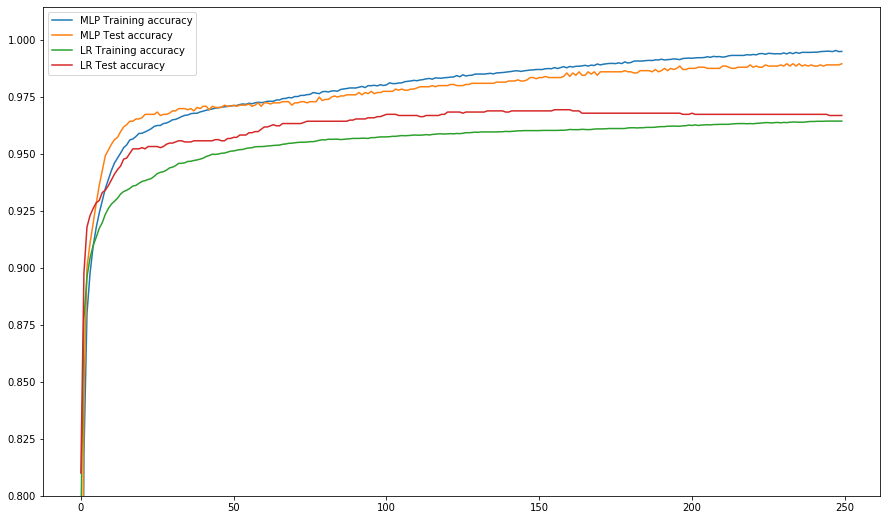

In [61]:
plt.figure(figsize=(15, 9))
plt.plot(nn_acc.accuracies, label = 'MLP Training accuracy')
plt.plot(nn_acc.test_accuracies, label = 'MLP Test accuracy')
plt.plot(lr_acc.accuracies, label = 'LR Training accuracy')
plt.plot(lr_acc.test_accuracies, label = 'LR Test accuracy')
plt.ylim(0.8)
plt.legend();

#### Result

In [62]:
#Taking a random image and classifying it as 3 or 8

In [63]:
def is_It_a_3_or_8(index):
    res_prob = nn_model(dataSet.X_test[index])
    res_pred = (res_prob >= 0.5)*1
    if res_pred:
        print("    ", f"The Image {index} is a '3' (Three)")
    else:
        print("    ", f"The image {index} is a '8' (Eight)")
    print()

In [64]:
print(f"We can say with {round(nn_validateTest_acc, 2)} accuracy that:")
print()
for i in range(10):
    index = np.random.randint(0, len(X_test), 1)[0]
    is_It_a_3_or_8(index)

We can say with 0.99 accuracy that:

     The Image 1253 is a '3' (Three)

     The Image 228 is a '3' (Three)

     The image 1684 is a '8' (Eight)

     The image 783 is a '8' (Eight)

     The Image 188 is a '3' (Three)

     The Image 1970 is a '3' (Three)

     The Image 254 is a '3' (Three)

     The Image 1363 is a '3' (Three)

     The Image 1881 is a '3' (Three)

     The image 304 is a '8' (Eight)

